<div style="background-color:white; text-align:center; font-family:Arial, Helvetica, sans-serif; padding:50px;">
  <!-- Tytuł -->
  <div style="color:#993520; font-size:60px; font-weight:bold; margin-bottom:20px;">
    SENTIMENT ANALYSIS
  </div>

  <!-- Podtytuł -->
  <div style="color:#993520; font-size:35px; margin-bottom:40px;">
    Corpus-based methods: semi-supervised approaches
  </div>

  <!-- Autor -->
  <div style="color:black; font-size:30px; margin-bottom:10px;">
    Maciej Świtała, PhD
  </div>

  <!-- Data / semestr -->
  <div style="color:black; font-size:30px; margin-bottom:50px;">
    Autumn 2025
  </div>

  <!-- Logo -->
  <div>
    <img src="img/wne-logo-new-en.jpg" alt="WNE Logo" style="max-width:400px; height:auto;">
  </div>
</div>


### 1. Intro

In [1]:
# !pip install pandas numpy matplotlib seaborn nltk scikit-learn networkx

In [2]:
import pandas as pd  # for working with data in DataFrames
import numpy as np  # numerical operations and arrays

import matplotlib.pyplot as plt  # data visualization
import seaborn as sns  # enhanced visualisation

import pickle  # data loading
import math  # mathematical functions
import time
import ast
import warnings  # to turn off specific warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message=".*token_pattern.*will not be used.*")

from collections import Counter  # counting occurrences of elements
from itertools import combinations  # generates all possible unique combinations of length; we will need it for generating all unique pairs of keywords

from nltk.probability import FreqDist  # frequency distribution of tokens
from nltk.tokenize import RegexpTokenizer  # for topic models in sklearn, nltk tokeniser is required

from sklearn.feature_extraction.text import TfidfVectorizer # example vectoriser for label propagation
from sklearn.feature_extraction.text import CountVectorizer # example vectoriser for label propagation
from sklearn.metrics.pairwise import cosine_similarity # cosine similarity for making a graph
from sklearn.semi_supervised import LabelPropagation
import networkx as nx # making a graph

from sklearn.decomposition import TruncatedSVD  # this performs LSA

In [3]:
# let us load an example dataset (already initially preprocessed); these are opinions on an individual McDonald's restaurant in the U.S.
data = pd.read_csv("data/nichecom-opinions-mcdonalds_cleaned.txt", sep="\t", encoding="utf-8")

In [4]:
data.head()

,Review,Rating,Position,Date,Review_cleaned
0,working for McDonald's is very unique you lear...,Rating 4 out of 5,Senior Employee,2024-09-30,"['working', 'mcdonalds', 'unique', 'learn', 'l..."
1,It have been great so far. The people are real...,Rating 3 out of 5,Entry Level Employee,2024-09-12,"['great', 'far', 'people', 'really', 'kind', '..."
2,The Mcdonalds that I work at is a very good jo...,Rating 3 out of 5,Manager / Director,2024-09-09,"['mcdonalds', 'work', 'good', 'job', 'problem'..."
3,While the workplace environment may not be per...,Rating 2 out of 5,Intern / Student Worker,2024-06-10,"['workplace', 'environment', 'may', 'perfect',..."
4,The overall experience of working at a McDonal...,Rating 3 out of 5,Other,2024-05-31,"['overall', 'experience', 'working', 'mcdonald..."


In [5]:
data.shape

(472, 5)

### 2. Data preprocessing

In [6]:
# this function generates n-grams for a list of tokens over a specified range of n values
def generate_ngrams(tokens, ngram_range=(1,3)):

    all_ngrams = []  # this list will store all generated n-grams

    # loop over each n in the range (e.g., 1, 2, 3)
    for n in range(ngram_range[0], ngram_range[1]+1):
        # create sliding windows of length n
        ngrams = zip(*[tokens[i:] for i in range(n)])  # e.g., for bigrams: [tokens[0:], tokens[1:]]
        
        # join tokens with underscores to form n-gram strings
        all_ngrams.extend(['_'.join(gram) for gram in ngrams])
    
    return all_ngrams  # return the complete list of n-grams

# apply n-gram generation to all cleaned texts
# texts_cleaned is a list of documents, each a list of tokens
texts_with_ngrams = [generate_ngrams(doc, ngram_range=(1,3)) for doc in data['Review_cleaned'].apply(ast.literal_eval)]

# after this step:
# - texts_with_ngrams[i] contains all unigrams, bigrams, and trigrams for document i
# - each n-gram is a single string (e.g., "new_york", "war_in_ukraine")

# show a sample of cleaned texts
# print(texts_with_ngrams[0])

# count unique tokens after incorporation of n-grams
freq_dict = Counter(token for doc in texts_with_ngrams for token in np.unique(doc))
# print('there are', len(freq_dict), 'unique tokens')

In [7]:
# this function computes TF, DF, IDF, TF-IDF for all the tokens under consideration

def compute_tfidf(texts):

    N = len(texts)  # number of documents
    
    # 1. Compute TF for each document
    tf_docs = []
    for doc in texts:
        counts = Counter(doc)
        total_words = len(doc)
        tf_doc = {word: count / total_words for word, count in counts.items()}
        tf_docs.append(tf_doc)
    
    # 2. Compute DF for each token (fraction of docs containing the token)
    df_dict = {}
    for doc in texts:
        for token in set(doc):
            df_dict[token] = df_dict.get(token, 0) + 1
    df_dict = {token: count / N for token, count in df_dict.items()}
    
    # 3. Compute IDF
    idf_dict = {token: math.log(1 / df) for token, df in df_dict.items()}
    
    # 4. Compute TF-IDF for each document
    tfidf_docs = []
    for tf_doc in tf_docs:
        tfidf_doc = {token: tf_val * idf_dict[token] for token, tf_val in tf_doc.items()}
        tfidf_docs.append(tfidf_doc)
    
    return tf_docs, df_dict, idf_dict, tfidf_docs

tf_docs, df_dict, idf_dict, tfidf_docs = compute_tfidf(texts_with_ngrams)

# usually we are interested in DF, primarily due to its intuitive interpretation
# initial analysis of DF is the first step towards filtering out the too frequent and too rare tokens

### 3. Label propagation algorithm

#### 3.1. Introduction to LPA implementations in Python

In [8]:
texts_string = pd.Series(texts_with_ngrams).map(lambda x: ' '.join(x)) # we need series with strings to run it

vectorizer = TfidfVectorizer() # example vectoriser, one could try other, yet TF-IDF is quite popular
vect = vectorizer.fit_transform(texts_string) # this returns a vector representation of texts

# visualisation of the vectorizer - Document-Term Matrix with TF-IDF scores
df_tfidf = pd.DataFrame(vect.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf

,_customer,_customer_always,_customer_pretty,_desperate,_desperate_,_dirty,_dirty_,_easy,_easy_first,_great,...,yum_ogga,yum_ogga_booga,yum_yum,yum_yum_ogga,yummy,yummy_yum,yummy_yum_yum,zone,zone_learned,zone_learned_handle
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
similarity_matrix = cosine_similarity(vect) # cosine similarity between the TF-IDF representations of texts
pd.DataFrame(similarity_matrix) # each cell is cosine similarity value between the TF-IDF representations of text

,0,1,2,3,4,5,6,7,8,9,...,462,463,464,465,466,467,468,469,470,471
0,1.000000,0.003053,0.002894,0.008918,0.020982,0.013219,0.003080,0.004071,0.037088,0.022594,...,0.007538,0.005484,0.009911,0.028446,0.004513,0.006091,0.008024,0.000000,0.003266,0.021474
1,0.003053,1.000000,0.022655,0.000000,0.022140,0.012731,0.044477,0.002076,0.024752,0.002933,...,0.009138,0.025794,0.024668,0.014245,0.013787,0.012563,0.001791,0.021028,0.011393,0.010082
2,0.002894,0.022655,1.000000,0.005776,0.005158,0.024403,0.009227,0.018116,0.018718,0.002781,...,0.003227,0.014818,0.005414,0.000000,0.020616,0.011908,0.009759,0.010229,0.017833,0.010852
3,0.008918,0.000000,0.005776,1.000000,0.009156,0.004066,0.000000,0.000000,0.000000,0.000000,...,0.016384,0.000000,0.006376,0.007517,0.000000,0.033466,0.017890,0.004534,0.011629,0.004932
4,0.020982,0.022140,0.005158,0.009156,1.000000,0.008149,0.006888,0.001992,0.022286,0.011057,...,0.024281,0.007747,0.032692,0.012373,0.042002,0.074612,0.003927,0.028084,0.004837,0.018164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,0.006091,0.012563,0.011908,0.033466,0.074612,0.004471,0.006556,0.045862,0.004126,0.000000,...,0.002239,0.010348,0.014812,0.027494,0.009287,1.000000,0.010547,0.002347,0.000000,0.000000
468,0.008024,0.001791,0.009759,0.017890,0.003927,0.003120,0.009253,0.005565,0.011088,0.009277,...,0.011148,0.003217,0.006420,0.002695,0.005386,0.010547,1.000000,0.008982,0.005960,0.009300
469,0.000000,0.021028,0.010229,0.004534,0.028084,0.007201,0.021416,0.000000,0.004793,0.009013,...,0.002533,0.003667,0.015821,0.000000,0.002347,0.002347,0.008982,1.000000,0.017881,0.010309
470,0.003266,0.011393,0.017833,0.011629,0.004837,0.010551,0.010811,0.002222,0.010925,0.003138,...,0.011753,0.010185,0.011978,0.010536,0.008372,0.000000,0.005960,0.017881,1.000000,0.007592


In [10]:
# let us score few documents manually
for review in data['Review'][0:5]: print(review)

working for McDonald's is very unique you learn a lot of things and you get to enjoy becoming friends with coworkers
It have been great so far. The people are really kind and welcoming. I have working in a few different fast food settings and so far this one has been my favorite. Although something the scheduling system in not always the best at being accurate but other than that they do a great job training and wecloming new hire. Overall it is a great job and I would recommend it especially for peoples first job.
The Mcdonalds that I work at is a very good job. The only problem with the job is the management and the owners. The management puts strict rules on the employees, such as requiring managers to request time off a month in advance. I understand that we are supposed to take our job very seriously but at the end of the day, we work at a fast food place.
While the workplace environment may not be perfect, the team I work with is truly amazing. Wished many things were changed as 

In [11]:
data['label'] = -1 # -1 denotes no label in this algorithm
data.loc[0:4, "label"] = [1, 1, 0, 0, 0] # 0 - negative sentiment, 1 - positive sentiment

In [12]:
# Label Propagation model, more: https://scikit-learn.org/dev/modules/generated/sklearn.semi_supervised.LabelPropagation.html
label_prop_model = LabelPropagation(
    kernel='rbf',       # alternative: 'knn'
    gamma=20,           # kernel parameter, for 'knn' kernel the parameter is n_neighbours
    max_iter=1000,      # maximum iteration number
    tol=0.001,          # convergence tolerance; threshold to consider the system steady
    n_jobs=None
)

label_prop_model.fit(similarity_matrix, data['label'])

# prediction for all '-1'
predictions = label_prop_model.transduction_
predictions

array([1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

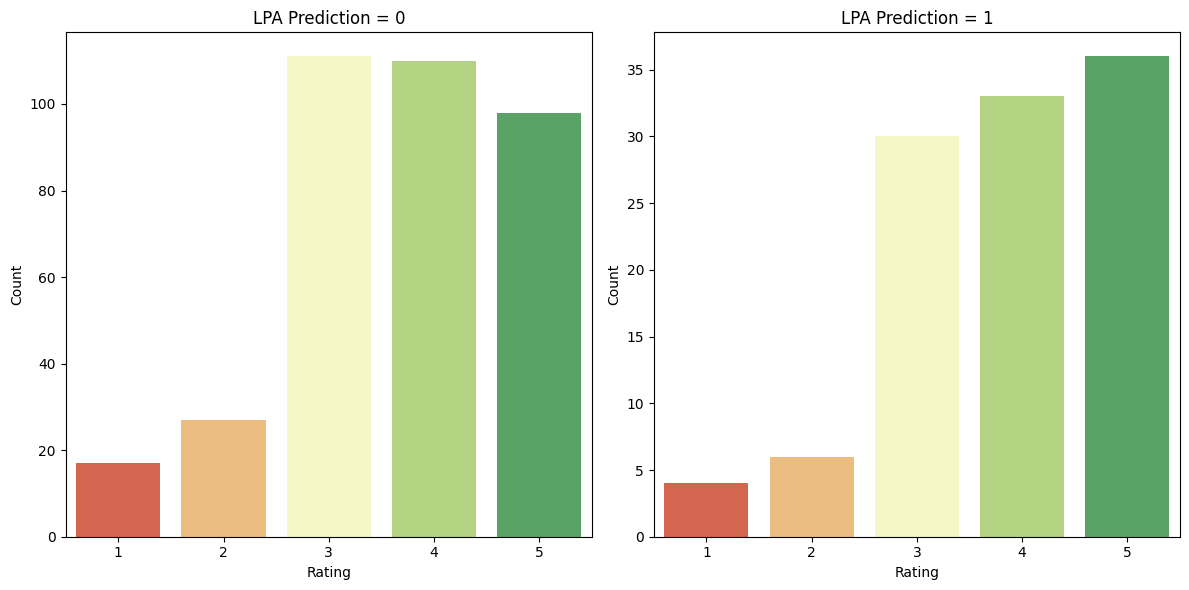

In [13]:
data['lpa_predictions'] = predictions

# convert Rating text to numeric
data['Rating_numeric'] = pd.to_numeric(
    data['Rating'].map(lambda x: x.split('Rating ')[1].split(' out of ')[0])
)

# get unique LPA prediction groups sorted ascending
groups = sorted(data['lpa_predictions'].unique())

# all possible ratings
all_ratings = sorted(data['Rating_numeric'].unique())

# create subplots
fig, axes = plt.subplots(1, len(groups), figsize=(12,6), sharey=False)

# red-to-green palette
num_ratings = len(all_ratings)
palette = sns.color_palette("RdYlGn", num_ratings)

# plot each group separately
for ax, group in zip(axes, groups):
    subset = data[data['lpa_predictions'] == group].copy()

    # ensure all ratings exist in the subset (even with count 0)
    subset['Rating_numeric'] = pd.Categorical(subset['Rating_numeric'], categories=all_ratings, ordered=True)

    sns.countplot(
        data=subset,
        x='Rating_numeric',
        hue='Rating_numeric',  # fix for future warning
        palette=palette,
        ax=ax,
        dodge=False,
        legend=False
    )
    ax.set_title(f'LPA Prediction = {group}')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

#### 3.2. LPA hyperparameters optimisation

In [14]:
# obviously, what we get is extremely dependent on the predefined scores, vectorizer method applied, 
# and similarity score considered. We can try exploring the obtained results with different measures

def compute_modularity(similarity_matrix, predictions, threshold):
    graph = nx.Graph()
    
    # adding nodes
    for i in range(similarity_matrix.shape[0]):
        graph.add_node(i)

    # adding edges
    for i in range(similarity_matrix.shape[0]):
        for j in range(i + 1, similarity_matrix.shape[0]):
            if similarity_matrix[i][j] >= threshold:  # creating a graph requires threshold (below a threshold - we treat it as an edge)
                graph.add_edge(i, j)

    # preparing communities from predictions
    unique_labels = np.unique(predictions)
    communities = []
    for label in unique_labels:
        if label != -1:  # assuming -1 indicates unclassified nodes
            communities.append(np.where(predictions == label)[0].tolist())

    # computing modularity
    modularity = nx.algorithms.community.modularity(graph, communities)

    return modularity

def compute_conductance(similarity_matrix, predictions, threshold):
    graph = nx.Graph()
    
    # adding nodes
    for i in range(similarity_matrix.shape[0]):
        graph.add_node(i)

    # adding edges
    for i in range(similarity_matrix.shape[0]):
        for j in range(i + 1, similarity_matrix.shape[0]):
            if similarity_matrix[i][j] >= threshold:  # creating a graph requires threshold (below a threshold - we treat it as an edge)
                graph.add_edge(i, j)

    # preparing communities from predictions
    unique_labels = np.unique(predictions)
    communities = []
    for label in unique_labels:
        if label != -1:  # assuming -1 indicates unclassified nodes
            communities.append(np.where(predictions == label)[0].tolist())
            
    conductance_values = {}
    for label in unique_labels:
        if label != -1: # assuming -1 indicates unclassified nodes
            community_nodes = np.where(predictions == label)[0]
            cut_edges = 0
            community_volume = 0
            
            # calculating edges and volume of communities
            for node in community_nodes:
                community_volume += graph.degree[node]
                for neighbor in graph.neighbors(node):
                    if predictions[neighbor] != label:
                        cut_edges += 1
            
            # computing conductance, small constant added to enable computation
            conductance_values[label] = cut_edges / max(min(community_volume, sum(graph.degree[n] for n in graph.nodes() if predictions[n] != label)),0.001)

    return conductance_values

print('modularity =',compute_modularity(similarity_matrix, predictions, 0.1))
print('community size distribution =',list(pd.Series(predictions).value_counts()/len(predictions)))
print('conductance =',list(compute_conductance(similarity_matrix, predictions, 0.1).values()))

# modularity close to 0 suggests a weak community structure
# communities are ~75% (negative sentiment) and ~25% (positive sentiment)
# conductance for both communities suggests a mediocre separation

modularity = 0.09568222354340071
community size distribution = [0.7690677966101694, 0.2309322033898305]
conductance = [0.5405405405405406, 0.5405405405405406]


In [15]:
start = time.time()

vectorizer_tfidf = TfidfVectorizer() # example vectorizer, one could try other, yet TF-IDF is quite popular
vect_tfidf = vectorizer.fit_transform(texts_string) # this returns a vector representation of texts

vectorizer_count = CountVectorizer() # another vectorizer
vect_count = vectorizer.fit_transform(texts_string) # this returns a vector representation of texts

results = []
for vect_name in ['vect_tfidf', 'vect_count']:
    
    if(vect_name == 'vect_tfidf'):
        vect = vect_tfidf
    elif(vect_name == 'vect_count'):
        vect = vect_count
    
    similarity_matrix = cosine_similarity(vect) # cosine similarity between the the representations of texts

    for number_of_labels in [2, 3, 5]:
        
        for obs_scored_manually in [5, 10, 15]:
        
            data['label'] = -1 # -1 denotes no label in this algorithm
        
            if(number_of_labels == 2): # 0 - negative, 1 - positive
                if(obs_scored_manually == 5):
                    data.loc[0:4, "label"] = [1, 1, 0, 0, 0]
                elif(obs_scored_manually == 10):
                    data.loc[0:9, "label"] = [1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
                elif(obs_scored_manually == 15):
                    data.loc[0:14, "label"] = [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0] 
            
            elif(number_of_labels == 3): # 0 - negative, 1 - neutral, 2 - positive
                if(obs_scored_manually == 5):
                    data.loc[0:4, "label"] = [2, 1, 0, 1, 1]
                elif(obs_scored_manually == 10):
                    data.loc[0:9, "label"] = [2, 1, 0, 1, 1, 1, 2, 2, 1, 2]
                elif(obs_scored_manually == 15):
                    data.loc[0:14, "label"] = [2, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 1]

            elif(number_of_labels == 5): # 0 - negative, 1 - slightly negative, 2 - neutral, 3 - slightly positive, 4 - positive
                if(obs_scored_manually == 5):
                    data.loc[0:4, "label"] = [1, 3, 1, 2, 2]
                elif(obs_scored_manually == 10):
                    data.loc[0:9, "label"] = [1, 3, 1, 2, 2, 3, 4, 4, 3, 4]
                elif(obs_scored_manually == 15):
                    data.loc[0:14, "label"] = [1, 3, 1, 2, 2, 3, 4, 4, 3, 4, 4, 0, 1, 3, 2]
            
            for kernel in ['rbf','knn']:
                
                if kernel == 'rbf':
                    for gamma in [10, 20, 40]:
                        n_neighbours = None

                        label_prop_model = LabelPropagation(
                            kernel=kernel,              # alternatives: 'knn', 'rbf'
                            gamma=gamma,                # rbf kernel parameter
                            max_iter=1000,              # maximum iteration number
                            tol=0.001,                  # convergence tolerance; threshold to consider the system steady
                            n_jobs=None
                        )

                        label_prop_model.fit(similarity_matrix, data['label'])
                        predictions = label_prop_model.transduction_
                        
                        modularity = compute_modularity(similarity_matrix, predictions, 0.1)
                        max_community_size = max(list(pd.Series(predictions).value_counts()/len(predictions)))
                        mean_conductance = np.mean(list(compute_conductance(similarity_matrix, predictions, 0.1).values()))
                        
                        results.append([vect_name, number_of_labels, obs_scored_manually, kernel, gamma, n_neighbours, modularity, max_community_size, mean_conductance])

                elif kernel == 'knn':
                    for n_neighbours in [5, 7, 9]:
                        gamma = None
            
                        label_prop_model = LabelPropagation(
                            kernel=kernel,              # alternatives: 'knn', 'rbf'
                            n_neighbors=n_neighbours,   # knn kernel parameter
                            max_iter=1000,              # maximum iteration number
                            tol=0.001,                  # convergence tolerance; threshold to consider the system steady
                            n_jobs=None
                        )

                        label_prop_model.fit(similarity_matrix, data['label'])
                        predictions = label_prop_model.transduction_
                        
                        modularity = compute_modularity(similarity_matrix, predictions, 0.1)
                        max_community_size = max(list(pd.Series(predictions).value_counts()/len(predictions)))
                        mean_conductance = np.mean(list(compute_conductance(similarity_matrix, predictions, 0.1).values()))
                        
                        results.append([vect_name, number_of_labels, obs_scored_manually, kernel, gamma, n_neighbours, modularity, max_community_size, mean_conductance])

print("--- %s seconds ---" % (time.time() - start))

--- 16.400679349899292 seconds ---


In [16]:
results_df = pd.DataFrame(results)
results_df.columns = ['vect_name','number_of_labels','obs_scored_manually','kernel','gamma','n_neighbours','modularity','max_community_size','mean_conductance']

In [17]:
results_df.sort_values(by='modularity', ascending=False).head()

,vect_name,number_of_labels,obs_scored_manually,kernel,gamma,n_neighbours,modularity,max_community_size,mean_conductance
20,vect_tfidf,3,5,rbf,40.0,NaN,0.231653,0.588983,0.396871
74,vect_count,3,5,rbf,40.0,NaN,0.231653,0.588983,0.396871
73,vect_count,3,5,rbf,20.0,NaN,0.231523,0.752119,0.433781
19,vect_tfidf,3,5,rbf,20.0,NaN,0.231523,0.752119,0.433781
30,vect_tfidf,3,15,rbf,10.0,NaN,0.226135,0.885593,0.531209


In [18]:
results_df.sort_values(by='max_community_size', ascending=True).head()

,vect_name,number_of_labels,obs_scored_manually,kernel,gamma,n_neighbours,modularity,max_community_size,mean_conductance
50,vect_tfidf,5,15,rbf,40.0,NaN,0.139770,0.317797,0.690000
104,vect_count,5,15,rbf,40.0,NaN,0.139770,0.317797,0.690000
103,vect_count,5,15,rbf,20.0,NaN,0.147341,0.343220,0.481592
49,vect_tfidf,5,15,rbf,20.0,NaN,0.147341,0.343220,0.481592
44,vect_tfidf,5,10,rbf,40.0,NaN,0.188726,0.349576,0.582727


In [19]:
results_df.sort_values(by='mean_conductance', ascending=False).head()

,vect_name,number_of_labels,obs_scored_manually,kernel,gamma,n_neighbours,modularity,max_community_size,mean_conductance
5,vect_tfidf,2,5,knn,NaN,9.0,-0.000009,0.985169,1.0
11,vect_tfidf,2,10,knn,NaN,9.0,-0.000009,0.993644,1.0
4,vect_tfidf,2,5,knn,NaN,7.0,-0.000009,0.995763,1.0
17,vect_tfidf,2,15,knn,NaN,9.0,-0.001821,0.970339,1.0
65,vect_count,2,10,knn,NaN,9.0,-0.000009,0.993644,1.0


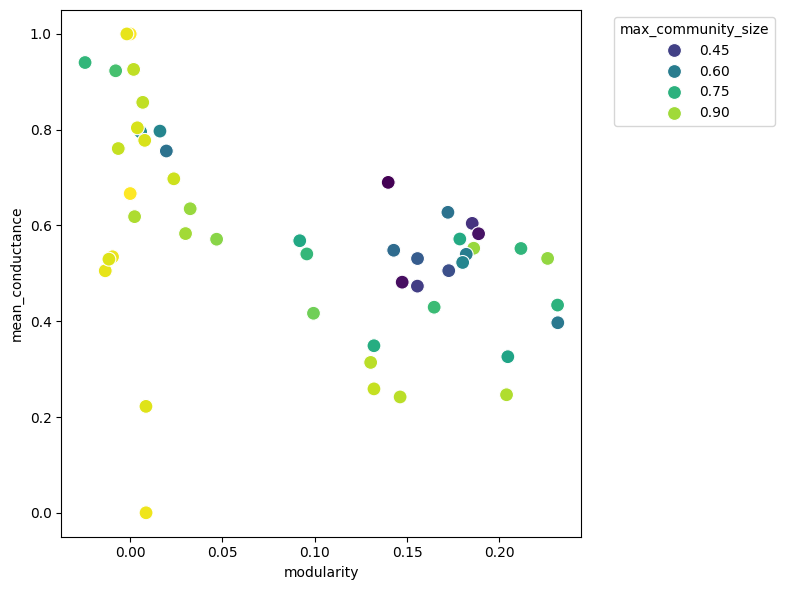

In [20]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=results_df,
    x='modularity',
    y='mean_conductance',
    hue='max_community_size',
    palette="viridis",
    s=100
)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.set_title('max_community_size')
plt.tight_layout()
plt.show()

#### 3.3. Possible optimal specifications

In [21]:
# possibly optimal specification (i.e, maximising modularity)

texts_string = pd.Series(texts_with_ngrams).map(lambda x: ' '.join(x)) # we need series with strings to run it
vectorizer = TfidfVectorizer() # example vectoriser, one could try other, yet TF-IDF is quite popular
vect = vectorizer.fit_transform(texts_string) # this returns a vector representation of texts
df_tfidf = pd.DataFrame(vect.toarray(), columns=vectorizer.get_feature_names_out()) # Document-Term Matrix with TF-IDF scores

similarity_matrix = cosine_similarity(vect) # cosine similarity between the TF-IDF representations of texts

data['label'] = -1 # -1 denotes no label in this algorithm
data.loc[0:4, "label"] = [2, 1, 0, 1, 1] # 0 - negative, 1 - neutral, 2 - positive

# possibly optimal specification of the hyperparameters 
label_prop_model = LabelPropagation(
    kernel='rbf',       # alternative: 'knn'
    gamma=40,           # kernel parameter
    max_iter=1000,      # maximum iteration number
    tol=0.001,          # convergence tolerance; threshold to consider the system steady
    n_jobs=None
)

label_prop_model.fit(similarity_matrix, data['label'])

# prediction for all '-1'
predictions = label_prop_model.transduction_

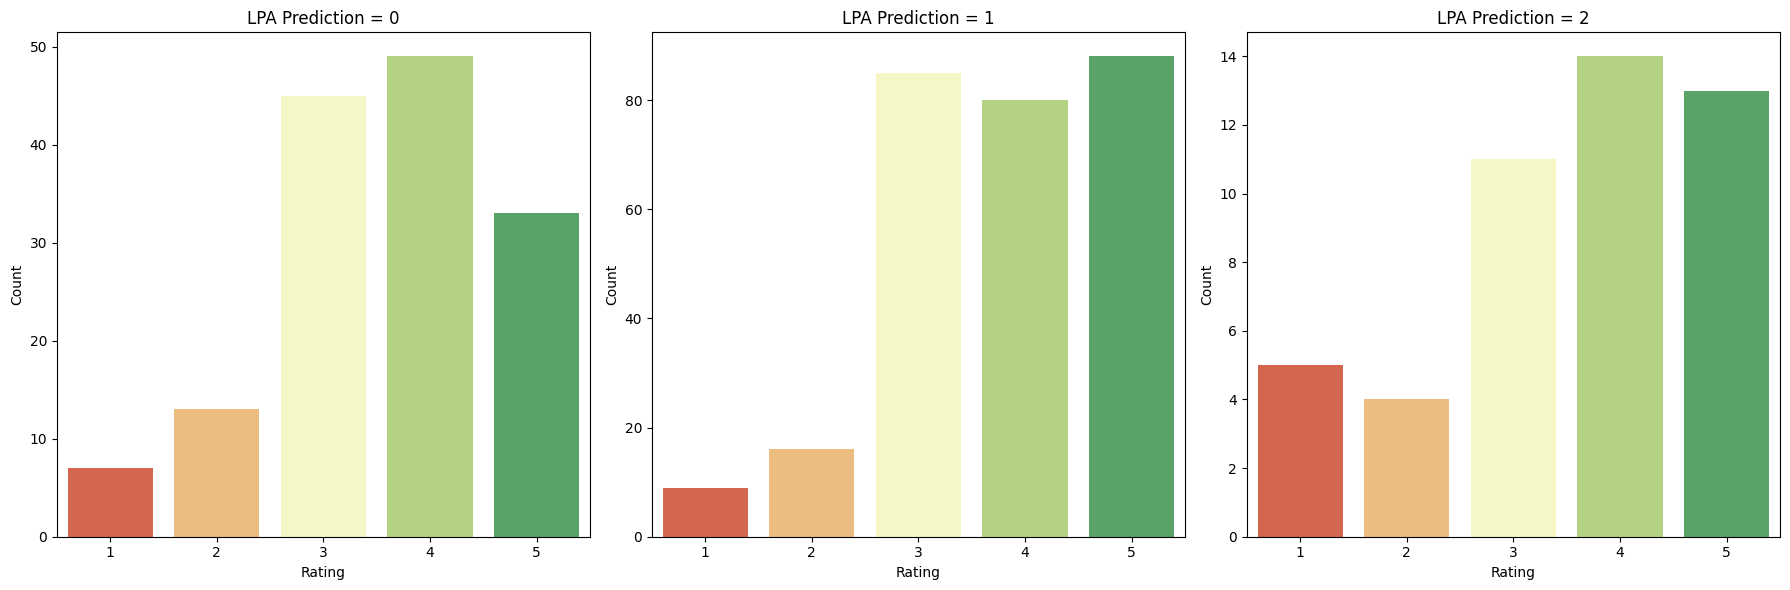

In [22]:
data['lpa_predictions'] = predictions

# convert Rating text to numeric
data['Rating_numeric'] = pd.to_numeric(
    data['Rating'].map(lambda x: x.split('Rating ')[1].split(' out of ')[0])
)

# get unique LPA prediction groups sorted ascending
groups = sorted(data['lpa_predictions'].unique())

# all possible ratings
all_ratings = sorted(data['Rating_numeric'].unique())

# create subplots
fig, axes = plt.subplots(1, len(groups), figsize=(18,6), sharey=False)

# red-to-green palette
num_ratings = len(all_ratings)
palette = sns.color_palette("RdYlGn", num_ratings)

# plot each group separately
for ax, group in zip(axes, groups):
    subset = data[data['lpa_predictions'] == group].copy()

    # ensure all ratings exist in the subset (even with count 0)
    subset['Rating_numeric'] = pd.Categorical(subset['Rating_numeric'], categories=all_ratings, ordered=True)

    sns.countplot(
        data=subset,
        x='Rating_numeric',
        hue='Rating_numeric',  # fix for future warning
        palette=palette,
        ax=ax,
        dodge=False,
        legend=False
    )
    ax.set_title(f'LPA Prediction = {group}')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [23]:
# possibly optimal specification (i.e, maximising mean_conductance)

texts_string = pd.Series(texts_with_ngrams).map(lambda x: ' '.join(x)) # we need series with strings to run it
vectorizer = TfidfVectorizer() # example vectoriser, one could try other, yet TF-IDF is quite popular
vect = vectorizer.fit_transform(texts_string) # this returns a vector representation of texts
df_tfidf = pd.DataFrame(vect.toarray(), columns=vectorizer.get_feature_names_out()) # Document-Term Matrix with TF-IDF scores

similarity_matrix = cosine_similarity(vect) # cosine similarity between the TF-IDF representations of texts

data['label'] = -1 # -1 denotes no label in this algorithm
data.loc[0:4, "label"] = [1, 1, 0, 0, 0] # 0 - negative, 1 - positive

# possibly optimal specification of the hyperparameters 
label_prop_model = LabelPropagation(
    kernel='knn',       # alternative: 'rbf'
    n_neighbors=9,     # kernel parameter
    max_iter=1000,      # maximum iteration number
    tol=0.001,          # convergence tolerance; threshold to consider the system steady
    n_jobs=None
)

label_prop_model.fit(similarity_matrix, data['label'])

# prediction for all '-1'
predictions = label_prop_model.transduction_

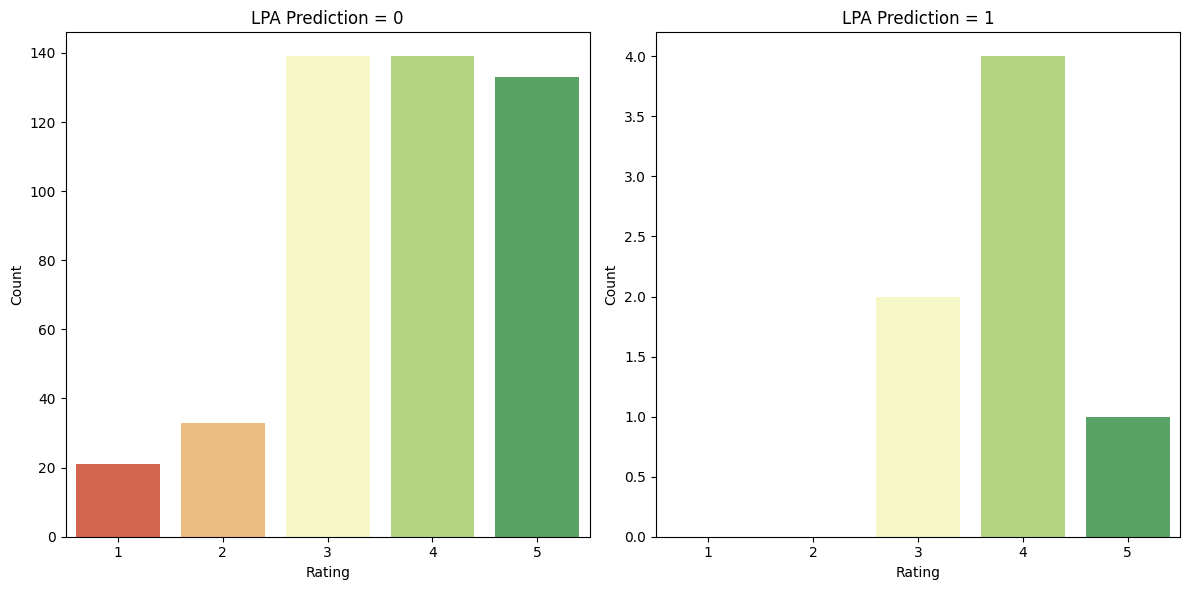

In [24]:
data['lpa_predictions'] = predictions

# convert Rating text to numeric
data['Rating_numeric'] = pd.to_numeric(
    data['Rating'].map(lambda x: x.split('Rating ')[1].split(' out of ')[0])
)

# get unique LPA prediction groups sorted ascending
groups = sorted(data['lpa_predictions'].unique())

# all possible ratings
all_ratings = sorted(data['Rating_numeric'].unique())

# create subplots
fig, axes = plt.subplots(1, len(groups), figsize=(12,6), sharey=False)

# red-to-green palette
num_ratings = len(all_ratings)
palette = sns.color_palette("RdYlGn", num_ratings)

# plot each group separately
for ax, group in zip(axes, groups):
    subset = data[data['lpa_predictions'] == group].copy()

    # ensure all ratings exist in the subset (even with count 0)
    subset['Rating_numeric'] = pd.Categorical(subset['Rating_numeric'], categories=all_ratings, ordered=True)

    sns.countplot(
        data=subset,
        x='Rating_numeric',
        hue='Rating_numeric',  # fix for future warning
        palette=palette,
        ax=ax,
        dodge=False,
        legend=False
    )
    ax.set_title(f'LPA Prediction = {group}')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [25]:
# possibly optimal specification (i.e, minimising max_community_size)

texts_string = pd.Series(texts_with_ngrams).map(lambda x: ' '.join(x)) # we need series with strings to run it
vectorizer = TfidfVectorizer() # example vectoriser, one could try other, yet TF-IDF is quite popular
vect = vectorizer.fit_transform(texts_string) # this returns a vector representation of texts
df_tfidf = pd.DataFrame(vect.toarray(), columns=vectorizer.get_feature_names_out()) # Document-Term Matrix with TF-IDF scores

similarity_matrix = cosine_similarity(vect) # cosine similarity between the TF-IDF representations of texts

data['label'] = -1 # -1 denotes no label in this algorithm
data.loc[0:14, "label"] = [1, 3, 1, 2, 2, 3, 4, 4, 3, 4, 4, 0, 1, 3, 2] # 0 - negative, 1 - slightly negative, 2 - neutral, 3 - slightly positive, 4 - positive

# possibly optimal specification of the hyperparameters 
label_prop_model = LabelPropagation(
    kernel='rbf',       # alternative: 'knn'
    gamma=40,           # kernel parameter
    max_iter=1000,      # maximum iteration number
    tol=0.001,          # convergence tolerance; threshold to consider the system steady
    n_jobs=None
)

label_prop_model.fit(similarity_matrix, data['label'])

# prediction for all '-1'
predictions = label_prop_model.transduction_

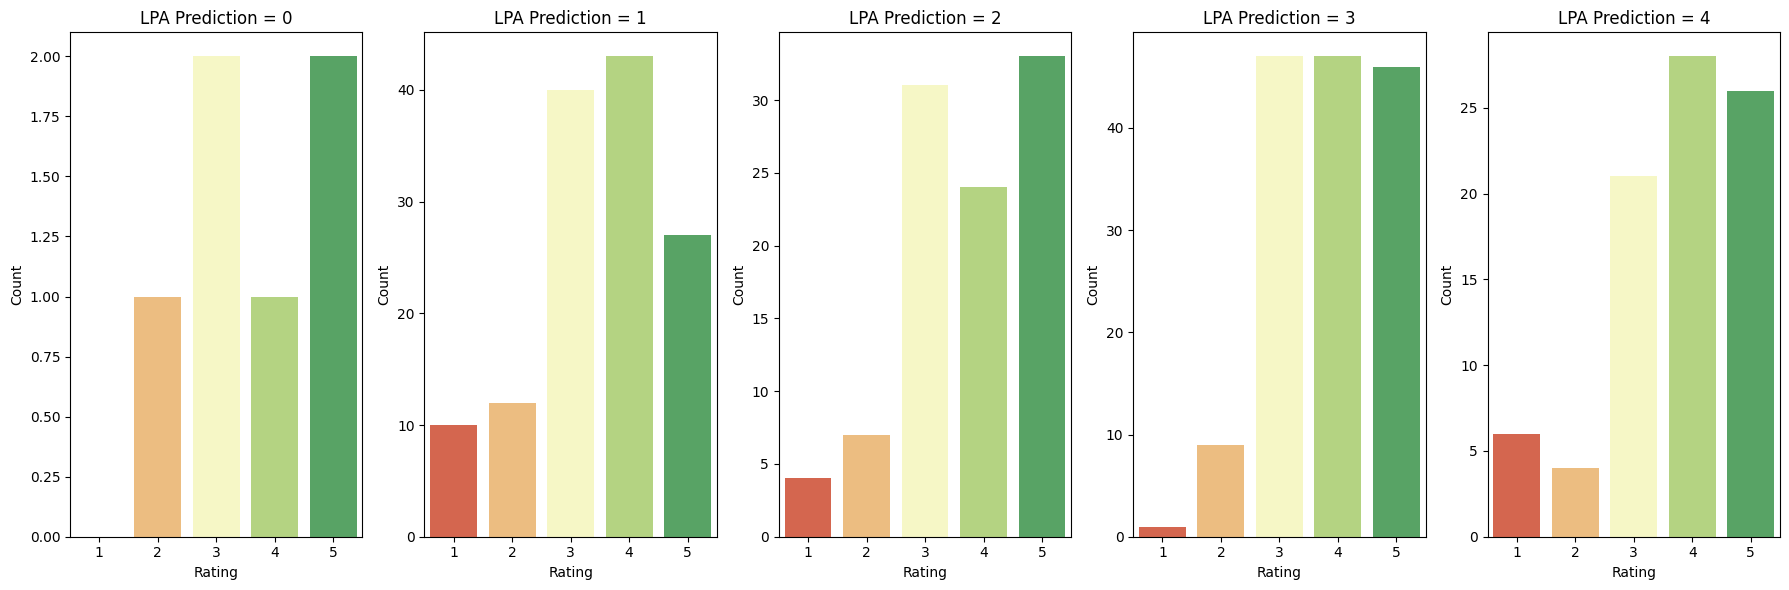

In [26]:
data['lpa_predictions'] = predictions

# convert Rating text to numeric
data['Rating_numeric'] = pd.to_numeric(
    data['Rating'].map(lambda x: x.split('Rating ')[1].split(' out of ')[0])
)

# get unique LPA prediction groups sorted ascending
groups = sorted(data['lpa_predictions'].unique())

# all possible ratings
all_ratings = sorted(data['Rating_numeric'].unique())

# create subplots
fig, axes = plt.subplots(1, len(groups), figsize=(18,6), sharey=False)

# red-to-green palette
num_ratings = len(all_ratings)
palette = sns.color_palette("RdYlGn", num_ratings)

# plot each group separately
for ax, group in zip(axes, groups):
    subset = data[data['lpa_predictions'] == group].copy()

    # ensure all ratings exist in the subset (even with count 0)
    subset['Rating_numeric'] = pd.Categorical(subset['Rating_numeric'], categories=all_ratings, ordered=True)

    sns.countplot(
        data=subset,
        x='Rating_numeric',
        hue='Rating_numeric',  # fix for future warning
        palette=palette,
        ax=ax,
        dodge=False,
        legend=False
    )
    ax.set_title(f'LPA Prediction = {group}')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

### 4. Latent variable models

#### 4.1. Modelling sentiment through topics with LSA algorithm

In [32]:
# let us build a topic model, i.e., an algorithm that extracts semantic structures from the text;
# in its simplest variant (i.e., Latent Semantic Analysis - LSA algorithm) an input is the Document-Term Matrix
# and an output includes weights of individual documents pointing to the latent dimentions (topics)

# simplest implementation of a topic model:

tokenizer = RegexpTokenizer(r'\w+') # tokenizer

tfidf_vectorizer = TfidfVectorizer(encoding = 'utf-8', # if bytes to analyze, this encoding will be used
                                   decode_error = 'strict', # if we want to get an error in case of encoding error
                                   strip_accents = None, # if we want to do something we accents
                                   
                                   lowercase = True, # all letters to lower case
                                   ngram_range = (1, 3), # what kind of ngrams do we want 
                                   
                                   max_df = 1.0, # filtering with document frequency, float means percentage, i.e., 1.0  denotes 100% (maximum DF value), integer means df value specifically
                                   min_df = 0.0, # filtering with document frequency
                                   max_features = None, # if we want to use only the tokens with top document frequency
                                   
                                   tokenizer = tokenizer.tokenize # tokenizer
)

tfidf = tfidf_vectorizer.fit_transform(data['Review_cleaned']) # using raw data for now
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out() # feature names

# specification of the model:
lsa = TruncatedSVD(n_components = 5, # number of topics
                   n_iter = 25, # number of iterations; more iterations -> more accurate but slower
                   random_state = 42) # random seed for reproducibility

model = lsa.fit_transform(tfidf) # fitting model on tokenised data

for index, component in enumerate(lsa.components_): # taking model's components (values from reconstructed Document-term matrix)
    zipped = zip(tfidf_feature_names, component) # taking together tokens' names with components
    top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:10] # top 10 terms per topic
    top_terms_str = ", ".join([f"{term} ({weight:.4f})" for term, weight in top_terms_key])
    print(f"Topic {index}: {top_terms_str}") # prints topic in one line

Topic 0: good (0.5930), work (0.2076), job (0.1746), mcdonalds (0.1519), working (0.1289), great (0.1187), people (0.1135), like (0.1105), customer (0.1085), experience (0.1026)
Topic 1: good (0.7634), good good (0.0946), good thing (0.0485), pretty good (0.0130), management good (0.0093), really good (0.0090), good management good (0.0082), acceptable (0.0077), acceptable service (0.0077), acceptable service good (0.0077)
Topic 2: bit poor (0.2577), hour pay (0.2577), hour pay bit (0.2577), mcdonalds hour (0.2577), mcdonalds hour pay (0.2577), okay work mcdonalds (0.2577), pay bit (0.2577), pay bit poor (0.2577), work mcdonalds hour (0.2577), okay work (0.2522)
Topic 3: like (0.3031), would (0.2131), would like (0.2041), see (0.2036), like see (0.1972), would like see (0.1863), change (0.1545), see change (0.1134), like see change (0.1062), thing (0.0740)
Topic 4: great (0.2518), work (0.2120), place (0.2051), great place (0.1683), flexible (0.1326), schedule (0.1294), place work (0.1

In [33]:
# to create a dictionary, we need to expertly score the topics
# let us assume that: -1 - very negative, -0.5 - slightly negative, 0 - neutral, +0.5 - slightly positive, +1 - very positive
sentiment_per_topic = [1, 1, -1, -0.5, 1]

In [34]:
# document-topic weights (the U matrix from the Singular Value Decomposition: X=UEV^T, where X is the Document-Term Matrix)
doc_topic_weights = pd.DataFrame(model)

# weights normalised to sum up to 1
doc_topic_probs_normalised = doc_topic_weights.div(doc_topic_weights.sum(axis=1), axis=0)

# here we multiply each row (topic probabilities per document) with the expertly specified sentiment values; next, we get sum of scores per document
sentiment_per_doc = doc_topic_probs_normalised.mul(sentiment_per_topic, axis=1).sum(axis=1)

<Axes: >

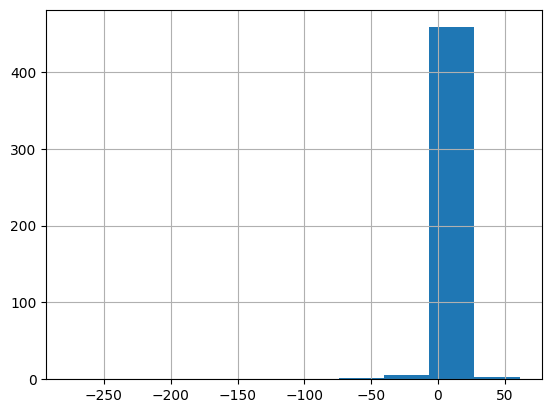

In [35]:
sentiment_per_doc.hist()

Text(0, 0.5, 'Rating')

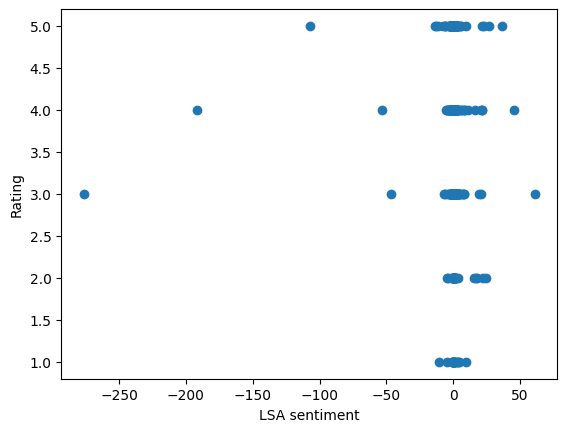

In [36]:
data['lsa_sentiment'] = sentiment_per_doc

plt.scatter(data['lsa_sentiment'], pd.to_numeric(data['Rating'].map(lambda x: x.split('Rating ')[1].split(' out of ')[0])))
plt.xlabel('LSA sentiment')
plt.ylabel('Rating')

#### 4.2. LSA optimisation

In [37]:
# count the number of documents containing a given word
def doc_freq(word):
    return sum(1 for doc in docs_as_sets if word in doc)

# count the number of documents containing both w1 and w2
def co_doc_freq(w1, w2):
    return sum(1 for doc in docs_as_sets if w1 in doc and w2 in doc)

# compute UMass coherence for a list of words (e.g., top words in a cluster/topic),normalized by the total number of word pairs
def umass_coherence(words, eps=1e-12):
    scores_sum = 0.0
    n_pairs = 0
    for w1, w2 in combinations(words, 2):  # iterate over all unique word pairs
        D_w1w2 = co_doc_freq(w1, w2)       # number of documents containing both words
        D_w2 = doc_freq(w2)                 # number of documents containing second word
        if D_w2 == 0:                       # skip to avoid division by zero
            continue
        scores_sum += np.log((D_w1w2 + eps) / D_w2)  # log-ratio with smoothing
        n_pairs += 1
    # normalize by total number of word pairs: 2 / (N*(N-1))
    return scores_sum * 2 / (len(words) * (len(words) - 1)) if n_pairs > 0 else 0.0

# compute UCI coherence (average PMI) for a list of words, normalized by all word pairs
def uci_coherence(words, eps=1e-12):
    scores_sum = 0.0
    n_pairs = 0
    for w1, w2 in combinations(words, 2):
        p_w1 = doc_freq(w1) / N           # probability of first word
        p_w2 = doc_freq(w2) / N           # probability of second word
        p_w1w2 = co_doc_freq(w1, w2) / N  # joint probability
        if p_w1 == 0 or p_w2 == 0:
            continue
        scores_sum += np.log((p_w1w2 + eps) / (p_w1 * p_w2))  # PMI
        n_pairs += 1
    return scores_sum * 2 / (len(words) * (len(words) - 1)) if n_pairs > 0 else 0.0

# compute UCI-style coherence using Normalized PMI (NPMI) for a list of words, normalized by all possible word pairs.
def uci_npmi_coherence(words, eps=1e-12):
    scores_sum = 0.0
    n_pairs = 0
    for w1, w2 in combinations(words, 2):
        p_w1 = doc_freq(w1) / N
        p_w2 = doc_freq(w2) / N
        p_w1w2 = co_doc_freq(w1, w2) / N
        if p_w1w2 == 0:
            continue
        pmi = np.log((p_w1w2 + eps) / (p_w1 * p_w2))  # compute PMI
        npmi = pmi / (-np.log(p_w1w2 + eps))          # normalize PMI
        scores_sum += npmi
        n_pairs += 1
    return scores_sum * 2 / (len(words) * (len(words) - 1)) if n_pairs > 0 else 0.0

In [ ]:
start = time.time()

results = []

tokenizer = RegexpTokenizer(r'\w+') # tokenizer
df_values = list(df_dict.values()) # get all DF values

for ngram_range in [1, 2, 3]:
    for max_df in [0.5, np.quantile(df_values, 0.999), np.quantile(df_values, 0.99)]:
        for min_df in [1, 2, 3]:
            for vectoriser in ['tf', 'tfidf']:
                if vectoriser=='tf':

                    vectorizer = CountVectorizer(encoding = 'utf-8', # if bytes to analyze, this encoding will be used
                                                    decode_error = 'strict', # if we want to get an error in case of encoding error
                                                    strip_accents = None, # if we want to do something we accents
                                                    
                                                    lowercase = True, # all letters to lower case
                                                    ngram_range = (1, ngram_range), # what kind of ngrams do we want 
                                                    
                                                    max_df = max_df, # filtering with document frequency, float means percentage, i.e., 1.0 denotes 100% (maximum DF value), integer means df value specifically
                                                    min_df = min_df, # filtering with document frequency
                                                    max_features = None, # if we want to use only the tokens with top document frequency
                                                    
                                                    tokenizer = tokenizer.tokenize # tokenizer
                    )

                    fit = vectorizer.fit_transform(data['Review_cleaned']) # using raw data for now
                    feature_names = vectorizer.get_feature_names_out() # feature names

                if vectoriser=='tfidf':
                    vectorizer = TfidfVectorizer(encoding = 'utf-8', # if bytes to analyze, this encoding will be used
                                                    decode_error = 'strict', # if we want to get an error in case of encoding error
                                                    strip_accents = None, # if we want to do something we accents
                                                    
                                                    lowercase = True, # all letters to lower case
                                                    ngram_range = (1, ngram_range), # what kind of ngrams do we want 
                                                    
                                                    max_df = max_df, # filtering with document frequency, float means percentage, i.e., 1.0 denotes 100% (maximum DF value), integer means df value specifically
                                                    min_df = min_df, # filtering with document frequency
                                                    max_features = None, # if we want to use only the tokens with top document frequency
                                                    
                                                    tokenizer = tokenizer.tokenize # tokenizer
                    )

                    fit = vectorizer.fit_transform(data['Review_cleaned']) # using raw data for now
                    feature_names = vectorizer.get_feature_names_out() # feature names

                for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:

                    print(ngram_range, max_df, min_df, vectoriser, k)

                    # specification of the model:
                    lsa = TruncatedSVD(n_components = k, # number of topics
                                       n_iter = 25, # number of iterations; more iterations -> more accurate but slower
                                       random_state = 42) # random seed for reproducibility

                    model = lsa.fit_transform(fit) # fitting model on tokenised data

                    # convert each document (list of tokens) into a set of unique tokens
                    docs_as_sets = [set(doc) for doc in data['Review_cleaned']]

                    # total number of documents in the corpus
                    N = len(docs_as_sets)

                    # compute coherence for all topics and accumulate
                    umass_all, uci_all, npmi_all = [], [], []

                    for index, component in enumerate(lsa.components_):
                        zipped = zip(feature_names, component)
                        top_terms_key = sorted(zipped, key=lambda t: t[1], reverse=True)[:10]
                        top_words = [term for term, weight in top_terms_key]

                        # compute coherence
                        umass_all.append(umass_coherence(top_words))
                        uci_all.append(uci_coherence(top_words))
                        npmi_all.append(uci_npmi_coherence(top_words))

                    # compute mean coherence
                    mean_umass = np.mean(umass_all)
                    mean_uci = np.mean(uci_all)
                    mean_npmi = np.mean(npmi_all)

                    results.append([ngram_range, max_df, min_df, vectoriser, k, mean_umass, mean_uci, mean_npmi])

with open("outputs/lsa_optimisation_results.pkl", "wb") as f:
    pickle.dump(results, f)

end = time.time()
elapsed_sec = end - start
elapsed_min = elapsed_sec / 60

print(f"Elapsed time: {elapsed_min:.2f} minutes") # it takes ~4 minutes

In [55]:
with open("outputs/lsa_optimisation_results.pkl", "rb") as f:
    results = pickle.load(f)

results_df = pd.DataFrame(results)
results_df.columns = ['ngram_range', 'max_df', 'min_df', 'vectoriser', 'k', 'mean_umass', 'mean_uci', 'mean_npmi']

In [56]:
results_df.sort_values('mean_umass', ascending=False).head()

,ngram_range,max_df,min_df,vectoriser,k,mean_umass,mean_uci,mean_npmi
537,3,0.137136,3,tfidf,40,0.0,0.0,0.0
0,1,0.500000,1,tf,5,0.0,0.0,0.0
1,1,0.500000,1,tf,10,0.0,0.0,0.0
2,1,0.500000,1,tf,15,0.0,0.0,0.0
3,1,0.500000,1,tf,20,0.0,0.0,0.0


In [57]:
results_df.sort_values('mean_uci', ascending=False).head(5)

,ngram_range,max_df,min_df,vectoriser,k,mean_umass,mean_uci,mean_npmi
0,1,0.5,1,tf,5,0.0,0.0,0.0
1,1,0.5,1,tf,10,0.0,0.0,0.0
2,1,0.5,1,tf,15,0.0,0.0,0.0
3,1,0.5,1,tf,20,0.0,0.0,0.0
4,1,0.5,1,tf,25,0.0,0.0,0.0


In [58]:
results_df.sort_values('mean_npmi', ascending=False).head(5)

,ngram_range,max_df,min_df,vectoriser,k,mean_umass,mean_uci,mean_npmi
0,1,0.5,1,tf,5,0.0,0.0,0.0
1,1,0.5,1,tf,10,0.0,0.0,0.0
2,1,0.5,1,tf,15,0.0,0.0,0.0
3,1,0.5,1,tf,20,0.0,0.0,0.0
4,1,0.5,1,tf,25,0.0,0.0,0.0


In [59]:
# select the last three columns as metrics
metrics = results_df.columns[-3:]

# normalize each metric using min-max normalization
normalized = results_df[metrics].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# create a new column as the sum of the normalized metrics
results_df['sum_normalised'] = normalized.sum(axis=1)

results_df.sort_values('sum_normalised', ascending=False).head(5)

,ngram_range,max_df,min_df,vectoriser,k,mean_umass,mean_uci,mean_npmi,sum_normalised
537,3,0.137136,3,tfidf,40,0.0,0.0,0.0,1.0
0,1,0.500000,1,tf,5,0.0,0.0,0.0,1.0
1,1,0.500000,1,tf,10,0.0,0.0,0.0,1.0
2,1,0.500000,1,tf,15,0.0,0.0,0.0,1.0
3,1,0.500000,1,tf,20,0.0,0.0,0.0,1.0


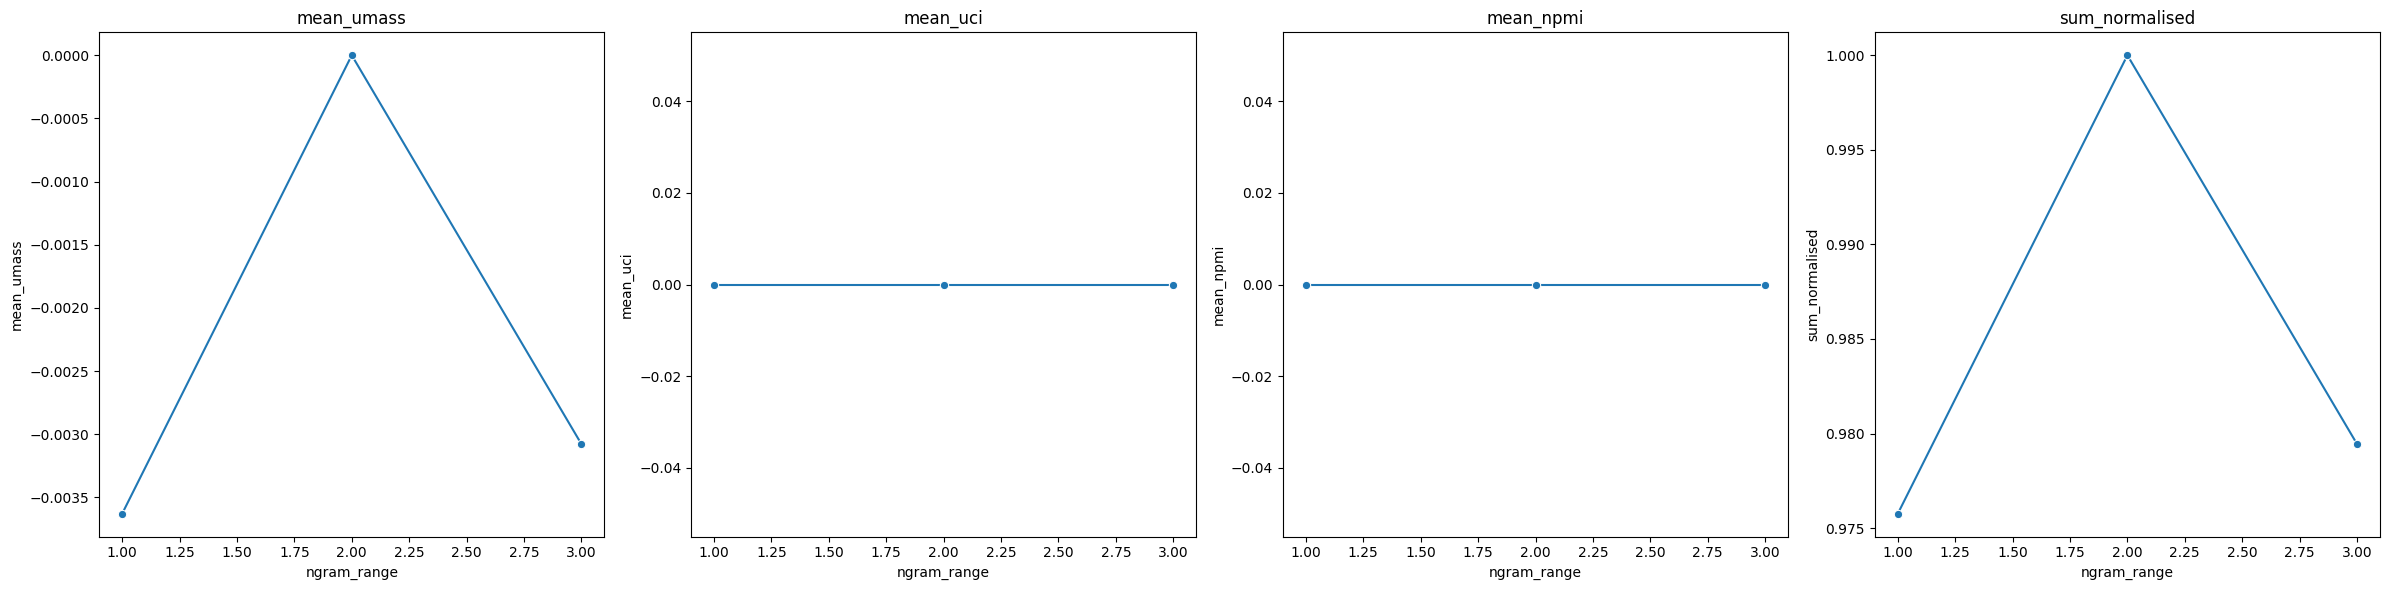

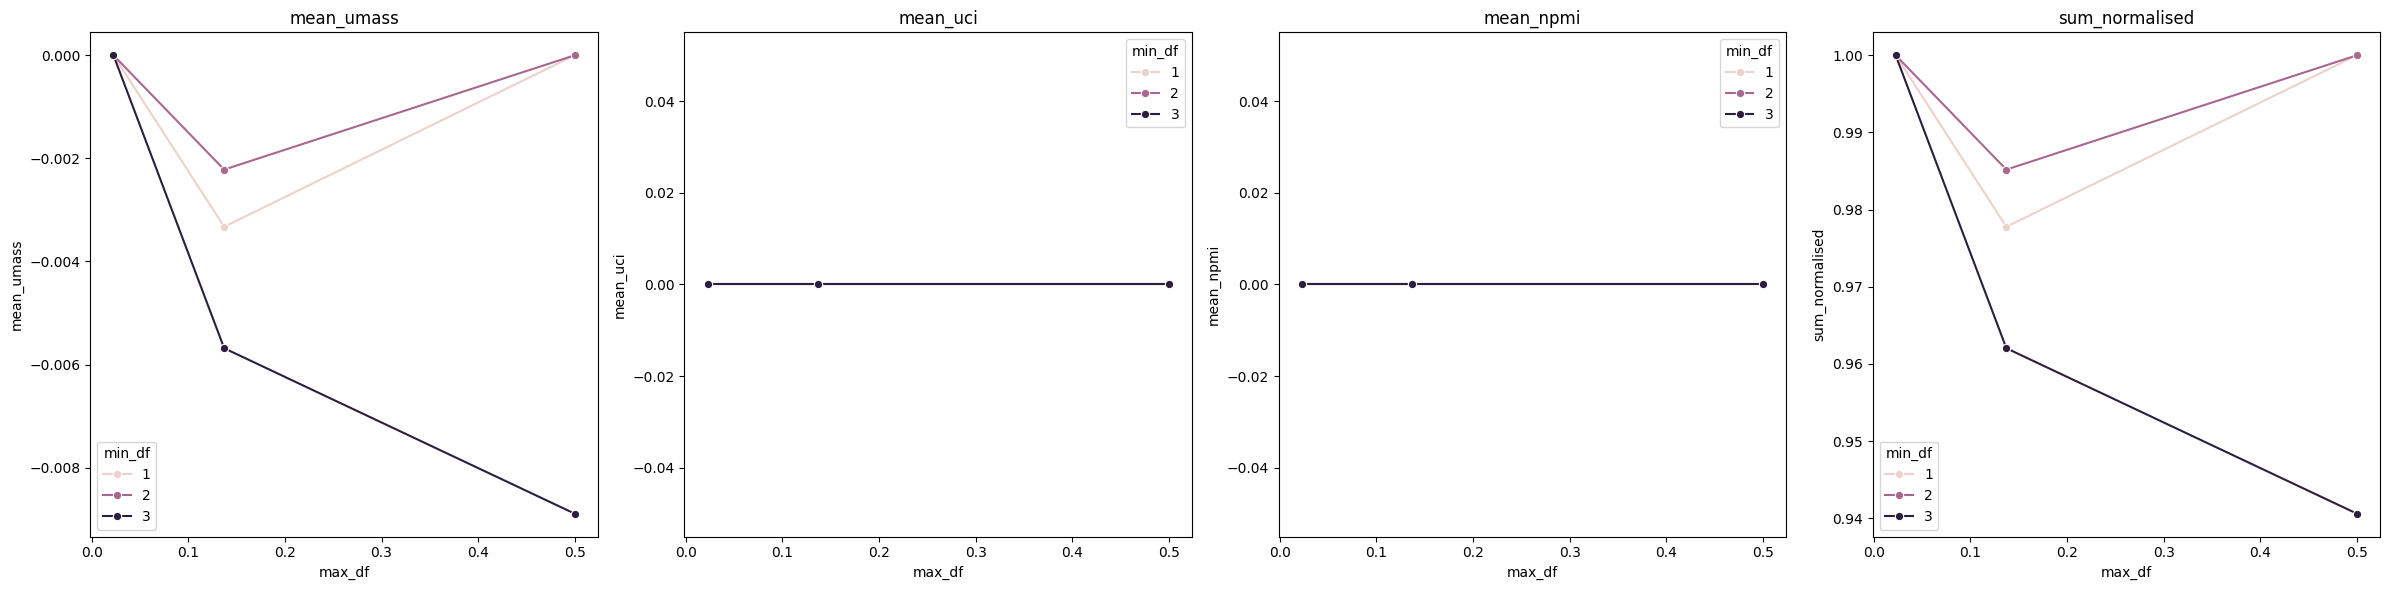

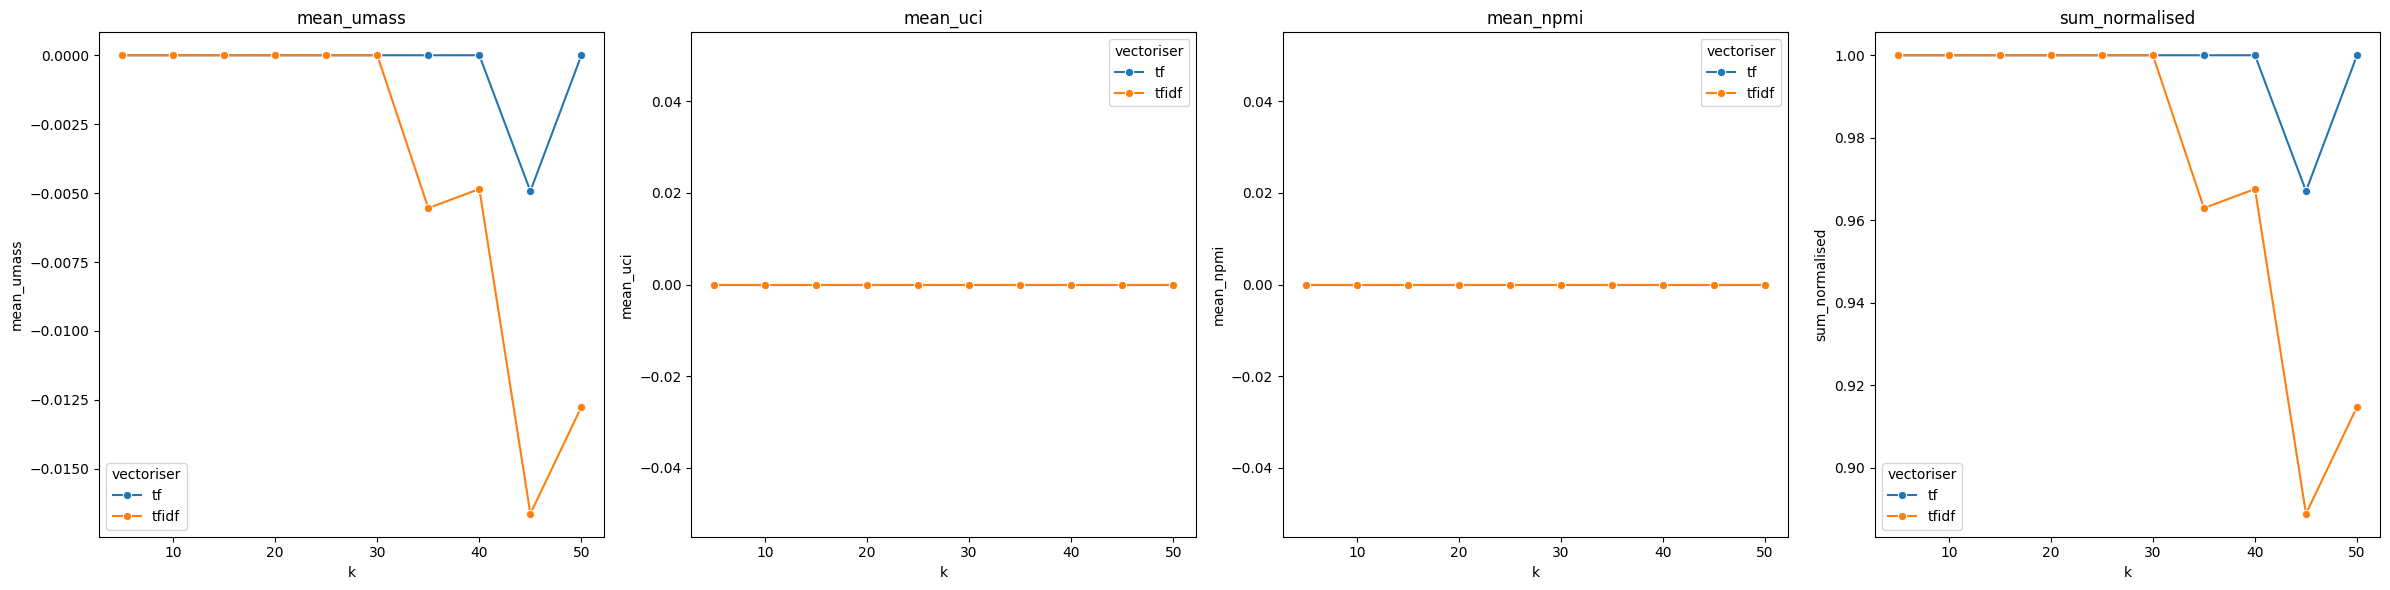

In [44]:
# let us examine the results with extra plots, showing coherence in subgroups of model parameters

# plot four line charts side by side for the last three metrics plus sum_normalized
def plot_four_line_charts(df, cols):

    # Ensure cols is a list
    if isinstance(cols, str):
        cols = [cols]
    if not (1 <= len(cols) <= 2):
        raise ValueError("Provide one or two column names.")

    metrics = df.columns[-4:]  # last four columns (3 metrics + sum_normalized)
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    x_col = cols[0]
    hue_col = cols[1] if len(cols) == 2 else None

    for ax, metric in zip(axes, metrics):
        if hue_col:
            sns.lineplot(data=df, x=x_col, y=metric, hue=hue_col, marker='o', ax=ax, errorbar=None)
        else:
            sns.lineplot(data=df, x=x_col, y=metric, marker='o', ax=ax, errorbar=None)

        ax.set_title(metric)
        ax.set_xlabel(x_col)
        ax.set_ylabel(metric)
        if hue_col:
            ax.legend(title=hue_col)

    plt.tight_layout()
    plt.show()

plot_four_line_charts(results_df, 'ngram_range')
plot_four_line_charts(results_df, ['max_df', 'min_df'])
plot_four_line_charts(results_df, ['k', 'vectoriser'])

#### 4.3. Optimal LSA specification + sentiment scores

In [61]:
tokenizer = RegexpTokenizer(r'\w+') # tokenizer

tfidf_vectorizer = TfidfVectorizer(encoding = 'utf-8', # if bytes to analyze, this encoding will be used
                                   decode_error = 'strict', # if we want to get an error in case of encoding error
                                   strip_accents = None, # if we want to do something we accents
                                   
                                   lowercase = True, # all letters to lower case
                                   ngram_range = (1, 2), # what kind of ngrams do we want 
                                   
                                   max_df = 0.5, # filtering with document frequency, float means percentage, i.e., 1.0  denotes 100% (maximum DF value), integer means df value specifically
                                   min_df = 2, # filtering with document frequency
                                   max_features = None, # if we want to use only the tokens with top document frequency
                                   
                                   tokenizer = tokenizer.tokenize # tokenizer
)

tfidf = tfidf_vectorizer.fit_transform(data['Review_cleaned']) # using raw data for now
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out() # feature names

# specification of the model:
lsa = TruncatedSVD(n_components = 30, # number of topics
                   n_iter = 25, # number of iterations; more iterations -> more accurate but slower
                   random_state = 42) # random seed for reproducibility

model = lsa.fit_transform(tfidf) # fitting model on tokenised data

for index, component in enumerate(lsa.components_): # taking model's components (values from reconstructed Document-term matrix)
    zipped = zip(tfidf_feature_names, component) # taking together tokens' names with components
    top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:10] # top 10 terms per topic
    top_terms_str = ", ".join([f"{term} ({weight:.4f})" for term, weight in top_terms_key])
    print(f"Topic {index}: {top_terms_str}") # prints topic in one line

Topic 0: work (0.2628), good (0.2371), job (0.2256), mcdonalds (0.1939), working (0.1723), great (0.1637), customer (0.1532), people (0.1485), get (0.1353), like (0.1344)
Topic 1: good (0.9054), food (0.0770), good good (0.0767), good place (0.0735), pretty good (0.0632), pretty (0.0566), management good (0.0450), good thing (0.0394), good work (0.0362), really good (0.0361)
Topic 2: great (0.5945), place (0.2445), great place (0.2036), food (0.1674), place work (0.1265), great experience (0.0951), customer (0.0920), service (0.0860), nice (0.0806), order (0.0785)
Topic 3: work (0.3155), hour (0.2562), schedule (0.2093), flexible (0.1801), okay work (0.1555), work mcdonalds (0.1524), bit poor (0.1454), hour pay (0.1454), mcdonalds hour (0.1454), pay bit (0.1454)
Topic 4: job (0.3451), first (0.2567), first job (0.2416), working (0.1683), school (0.1371), mcdonalds (0.0992), around (0.0964), working mcdonalds (0.0958), great first (0.0912), year (0.0909)
Topic 5: like (0.2826), great (0

In [62]:
# to create a dictionary, we need to expertly score the topics
# let us assume that: -1 - very negative, -0.5 - slightly negative, 0 - neutral, +0.5 - slightly positive, +1 - very positive
sentiment_per_topic = [
    0.5, 1, 1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0.5, 0.5, 1, 0, 0, 1, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0
]

In [63]:
# document-topic weights (the U matrix from the Singular Value Decomposition: X=UEV^T, where X is the Document-Term Matrix)
doc_topic_weights = pd.DataFrame(model)

# weights normalised to sum up to 1
doc_topic_probs_normalised = doc_topic_weights.div(doc_topic_weights.sum(axis=1), axis=0)

# here we multiply each row (topic probabilities per document) with the expertly specified sentiment values; next, we get sum of scores per document
sentiment_per_doc = doc_topic_probs_normalised.mul(sentiment_per_topic, axis=1).sum(axis=1)

<Axes: >

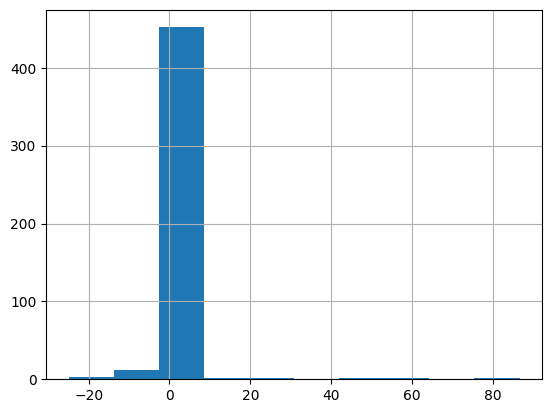

In [64]:
sentiment_per_doc.hist()

Text(0, 0.5, 'Rating')

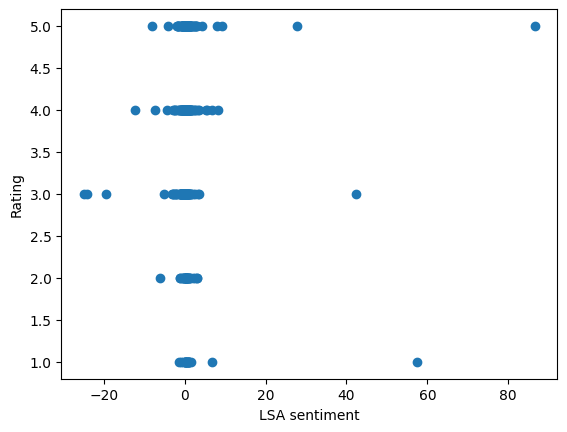

In [65]:
data['lsa_sentiment'] = sentiment_per_doc

plt.scatter(data['lsa_sentiment'], pd.to_numeric(data['Rating'].map(lambda x: x.split('Rating ')[1].split(' out of ')[0])))
plt.xlabel('LSA sentiment')
plt.ylabel('Rating')